## Image Classification with EfficientNet
The [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) architecture provides a simple and efficient way to improve convolutional neural network model performance by simultaneously scaling  network depth, width, and resolution. In this example, we will show  how we can apply the EfficientNet model for image classification tasks to obtain great accuracy. The end-to-end image classification example consists of the sequence of steps:

1. [Import Python Packages and Launch CAS Session](#import-packages-and-connect-CAS)
2. [Prepare Images for Training, Validation and Test](#prepare-image-datasets)
3. [Image Classification with EfficientNet](#image-classification-efficientnet)
    1. [Build An EfficientNet Model](#build-effb0)
    2. [Train the EfficientNet Model](#train-effb0)
    3. [Evaluate the EfficientNet Model](#evaluate-effb0)
    4. [Build a Smaller EfficientNet Model](#build-smaller-effb0)
    5. [Train the Smaller EfficientNet Model](#train-smaller-effb0)
    6. [Evaluate the Smaller EfficientNet Model](#evaluate-smaller-effb0)    
4. [Deploy Model](#deployment)
5. [Summary](#summary)

## 1. Import Packages and Launch a CAS Session <a name="import-packages-and-connect-CAS"></a>

In [1]:
import swat as sw
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from dlpy import Model, Sequential
from dlpy.model import *
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import Optimizer
from dlpy.lr_scheduler import *

### Launch a CAS Session

In [2]:
# Start a CAS session
your_host_name='cloud.example.com'
your_port_number='5570'
s = sw.CAS(your_host_name, your_port_number)

s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('astore')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000873s, sys: 0.000849s, mem: 0.204mb

## 2. Prepare Images for Training, Validation and Testing <a name="prepare-image-datasets">

###  Fruits-360 Image Data Set <a name="configuration"></a>
In this example, the Fruits-360 image data set from https://github.com/Horea94/Fruit-Images-Dataset is used for our image classification task. These images include 120 classes of fruits and vegetables. Training data set contains 61488 images, while the test data set contains 20622 images. The image size is 100*100.  

In [3]:
# set data directory path
dir_path = '/path/to/Fruit-Images-Dataset/'
# load images into CAS Tables
trainImgTbl = ImageTable.load_files(s, path=dir_path + 'Training', casout=dict(name='train'))
testImgTbl = ImageTable.load_files(s, path=dir_path + 'Test', casout=dict(name='test'))

print("Number of images for training:", trainImgTbl.numrows()["numrows"])
print("Number of images for validation:", testImgTbl.numrows()["numrows"])

Number of images for training: 61488
Number of images for validation: 20622


### Understand the Data

### 2.1 Display Randomly Selected Images

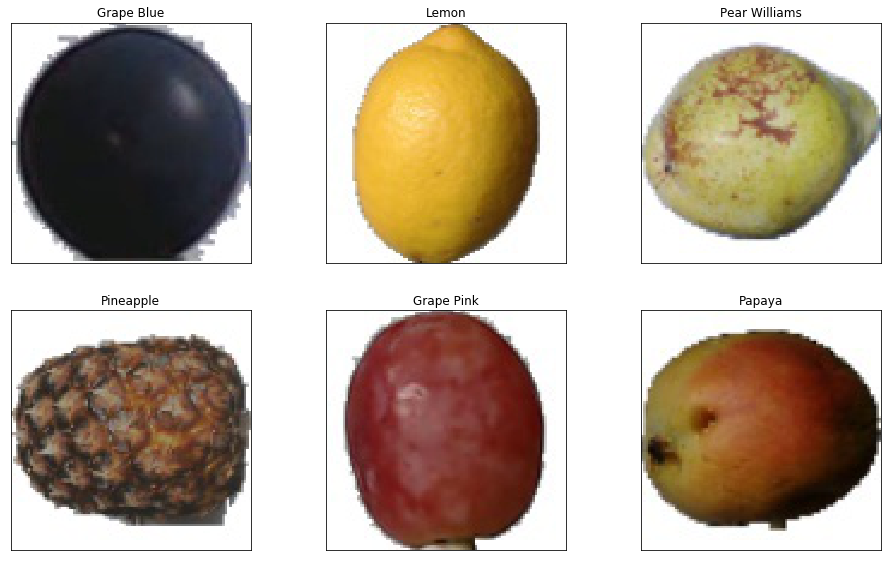

In [4]:
trainImgTbl.show(6,ncol=3,randomize=True)

### 2.2 Summary On  the Training and Test Images
- Number of images
- Image size
- Means of each channel

In [5]:
# summary information on the train image data
trainImgTbl.image_summary

jpg                 61488
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel     126.52
min1stChannel           0
max1stChannel         255
mean2ndChannel    146.276
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    174.217
min3rdChannel           0
max3rdChannel         255
dtype: object

Note: The summary table above shows that there are 61488 images with image size (100*100) in the training data set.
Here the channel means will be used as the offsets to normalize image inputs when we define CNN models later.

In [6]:
# summary on the test image data
testImgTbl.image_summary

jpg                 20622
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    129.699
min1stChannel           0
max1stChannel         255
mean2ndChannel    149.208
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     176.08
min3rdChannel           0
max3rdChannel         255
dtype: object

### 2.3 Distribution of the Image Classes/Labels in the Training Data

In [7]:
freq= trainImgTbl.label_freq
print("The minimum number of images among each class: ", np.min(freq["Frequency"]))
print("The maximum number of images among each class: ", np.max(freq["Frequency"]))
print(freq)

The minimum number of images among each class:  297
The maximum number of images among each class:  984
Frequency for TRAIN

                    Level  Frequency
Apple Braeburn          1        492
Apple Crimson Snow      2        444
Apple Golden 1          3        492
Apple Golden 2          4        492
Apple Golden 3          5        481
...                   ...        ...
Tomato 4              116        479
Tomato Cherry Red     117        492
Tomato Maroon         118        367
Tomato Yellow         119        459
Walnut                120        735

[120 rows x 2 columns]


The frequency table above shows that the training table contains 120 fruits and vegetables, and the number of images in each class ranges from 297 to 984.

### 2.4 Split Images Data for Training and Validation

In [8]:
# split training image data into train and validation
train_data, validation_data = two_way_split(trainImgTbl, test_rate=15, seed=12345)

In [9]:
print("Number of images for training:", train_data.numrows()["numrows"])
print("Number of images for validation:", validation_data.numrows()["numrows"])

Number of images for training: 52233
Number of images for validation: 9255


## 3. Image Classification with EfficientNet <a name="image-classification-efficientnet">
The EfficientNet models contains a family of CNN models. The EfficientNet-B0 model is an efficient baseline network, which is used to scale up to obtain other EfficientNets models (B1 to B7). We can build and apply these EfficientNets by DLPy APIs easily. From the [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) paper, we can see that the EfficientNet-B0 model is 4 times smaller than ResNet50, while it can achieves slightly better accuracy than ReseNet50. In this example, we will use the EfficientNet-B0 model for our fruits and vegatables classification task.  

### 3.1 Build an EfficientNet Model <a name="build-effb0"></a>
Next, you can build an EfficientNet model through DLPy API EfficientNetB0:
- We specify n_classes=120, which is the number of fruits and vegetables in the data set.
- Normalizing inputs can often improve model convergence during training. Here the input images are normalized with  offsets and norm_stds, where the offsets are set as the channel means from the training images. 
- Augmenting images (e.g. random flip, random crop,  random mutation) can often help train models with better generalization, which can potentially improve model accuracy on test images.

In [10]:
## Instantiate an EfficientNetB0 model
offsets = [126.519793, 146.276162,174.217395]
norm_stds = [255/2.,255/2.,255/2.]
effnetb0 = EfficientNetB0(conn=s, 
                          n_classes=120, 
                          offsets=offsets, norm_stds=norm_stds,
                          random_flip="hv", random_crop="resizethencrop", random_mutation="random"
                         )     

NOTE: Model compiled successfully.


### Summary on the model architecture
- It is a good start to verify the input and output layers. Since the input layer is $224 \times 224 \times 3$ for the EfficientNet-B0 model, we need resize the images in the data set, which can be conveniently done by the random_crop option. The output layer is for classification with 120 classes, which should be number of classes in the data set.
- The model has around 4.2 millions parameters, which is much smaller than the popular ResNet50 model with over 23 millions parameters.

In [11]:
effnetb0.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Conv1,convo,"(3, 3)","(2, 2)",Identity,"(112, 112, 32)","(864, 0)",10838016
2,2,bn_Conv1,batchnorm,,,Relu,"(112, 112, 32)","(0, 64)",0
3,3,stage_1_block_0depthwise,groupconvo,"(3, 3)","(1, 1)",Identity,"(112, 112, 32)","(288, 0)",3612672
4,4,stage_1_block_0depthwise_BN,batchnorm,,,Relu,"(112, 112, 32)","(0, 64)",0
...,...,...,...,...,...,...,...,...,...
178,178,Conv_top_bn,batchnorm,,,Relu,"(7, 7, 1280)","(0, 2560)",0
179,179,Global_avg_pool,pool,"(7, 7)","(1, 1)",Mean,"(1, 1, 1280)","(0, 0)",0
180,180,OutputLayer_1,output,,,Softmax,120,"(153600, 120)",0
181,,,,,,,,Total number of parameters,Total FLOPS


### 3.2 Train the EfficientNet Model<a name="train-effb0"></a>

### Set up optimizer for training  model

In [12]:
# set up varibles with number of epoches, number of threads, batch size
nEpoch=80
nThread=4
batchSize = 128
miniBatch= math.ceil(batchSize/nThread)

# set up optimizer with learning rate scheduler
lr_scheduler = ReduceLROnPlateau(conn=s, cool_down_iters=3, gamma=0.8, 
                                 learning_rate=0.001, patience=5)
solver = MomentumSolver(lr_scheduler=lr_scheduler,
                        clip_grad_max = 100, clip_grad_min = -100)                       
optimizer = Optimizer(seed=12345, algorithm=solver, mini_batch_size = miniBatch, 
                      log_level=2, max_epochs=nEpoch, reg_l2=0.0005)
## run on two gpus
gpu = Gpu(devices=[0,1])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


### Start training model

In [13]:
# start training
model= effnetb0
print(model.model_name)
print(dict(batchSize=batchSize, nThread=nThread, nEpoch=nEpoch))
train_history = model.fit(data = train_data,
                      valid_table = validation_data,
                      n_threads=nThread, record_seed=13309, optimizer=optimizer,
                      inputs = ['_image_'], 
                      gpu = gpu,train_from_scratch =True)


EfficientNetB0
{'batchSize': 128, 'nThread': 4, 'nEpoch': 80}
NOTE: Training from scratch.
NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 4161268.
NOTE:  The approximate memory cost is 411.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       5.97 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level      6: Apple P

NOTE:  27        0.001         0.01993   0.002827          0.02159          0.00443    58.13
NOTE:  28        0.001         0.01955   0.002827          0.01012         0.001945    58.39
NOTE:  29        0.001         0.01681    0.00233          0.01595         0.003458    58.38
NOTE:  30        0.001         0.01793   0.002732          0.02715         0.003998    58.10
NOTE:  31        0.001           0.016   0.002197          0.01254         0.003025    58.36
NOTE:  32        0.001         0.01666   0.002617          0.01519         0.002701    58.24
NOTE:  33        0.001         0.01474   0.002063         0.007542        0.0009724    58.14
NOTE:  34        0.001         0.01404   0.001967          0.01395         0.003133    58.42
NOTE:  35        0.001         0.01331   0.001681         0.004588        0.0003241    58.24
NOTE:  36        0.001         0.01392   0.001757         0.007171        0.0007563    58.31
NOTE:  37        0.001         0.01253   0.001433         0.007037    

### Learning curves for model convergence and overfitting 
- We plot the model accuracy on the training and validation data sets below. The plot shows that  the model starts to converge quickly. There is no much difference between training and validation accuracy, which indicates that overfitting is not a problem.

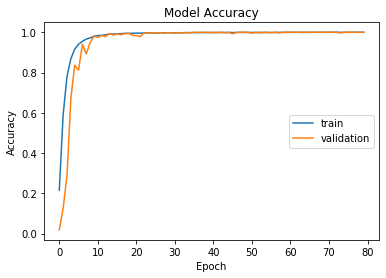

In [14]:
# summarize history for model accuracy
history = train_history["OptIterHistory"]
plt.plot(1.-history["FitError"])
plt.plot(1.-history["ValidError"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

### 3.3 Evaluate the EfficientNet Model <a name="evaluate-effb0"></a>

In [15]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, topprobs=5)

NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.


,Descr,Value
0,Number of Observations Read,20622
1,Number of Observations Used,20622
2,Misclassification Error (%),0.974687
3,Top 5 Misclassification Error (%),0.082436
4,Loss Error,0.03424


After scoring on the test images, the EfficientNet model achieves over 99% accuracy.

### 3.4 Build a Smaller EfficientNet Model<a name="build-smaller-effb0"></a>
We know that EfficientNet-B0 can be scaled up to obtain EfficientNet-B1 to B7 with better accuracy. For our fruits and vegetable classification, the EfficientNet-B0 model is already quit accurate. 

On the other hand, applications on mobile devices can benefit from small models that can be run in a timely fashion with high accuracy, which can be doned by scaling down the EfficientNet models.

In [16]:
effnetb0_smaller = EfficientNet(conn=s, model_table="EfficientNetB0_Smaller", 
                              n_classes=120,
                              width=100, height=100, 
                              width_coefficient=0.8, depth_coefficient=0.8,
                              offsets=offsets, norm_stds=norm_stds,
                              random_flip="hv", random_crop="resizethencrop", random_mutation="random"
                             )

NOTE: Model compiled successfully.


We instantiate a smaller EfficientNet model than the Efficient-B0 by scaling down network's input size, width and depth. Here we specify both width and height in the input layer as 100, which is the same as the image size in the training data set. Compared to EfficientNet-B0, the depth and the width are both scaled down by .8. 

## Summary on the model architecture

In [17]:
effnetb0_smaller.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(100, 100, 3)","(0, 0)",0
1,1,Conv1,convo,"(3, 3)","(2, 2)",Identity,"(50, 50, 24)","(648, 0)",1620000
2,2,bn_Conv1,batchnorm,,,Relu,"(50, 50, 24)","(0, 48)",0
3,3,stage_1_block_0depthwise,groupconvo,"(3, 3)","(1, 1)",Identity,"(50, 50, 24)","(216, 0)",540000
4,4,stage_1_block_0depthwise_BN,batchnorm,,,Relu,"(50, 50, 24)","(0, 48)",0
...,...,...,...,...,...,...,...,...,...
178,178,Conv_top_bn,batchnorm,,,Relu,"(4, 4, 1024)","(0, 2048)",0
179,179,Global_avg_pool,pool,"(4, 4)","(1, 1)",Mean,"(1, 1, 1024)","(0, 0)",0
180,180,OutputLayer_2,output,,,Softmax,120,"(122880, 120)",0
181,,,,,,,,Total number of parameters,Total FLOPS


### 3.5 Train the Smaller EfficientNet Model<a name="train-smaller-effb0"></a>

In [18]:
# start training
model= effnetb0_smaller
print(model.model_name)

train_history = model.fit(data = train_data,
                      valid_table = validation_data,
                      n_threads=nThread, record_seed=13309, optimizer=optimizer,
                      inputs = ['_image_'], 
                      gpu = gpu,train_from_scratch =True)


EfficientNetB0_Smaller
NOTE: Training from scratch.
NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 2689616.
NOTE:  The approximate memory cost is 103.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.30 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level      6: Apple Pink Lady    
NOTE:  Level      7: Apple

NOTE:  28        0.001         0.03395   0.007048          0.04315          0.01048    15.72
NOTE:  29        0.001         0.02978   0.005616              0.2          0.05413    15.82
NOTE:  30        0.001         0.03085   0.006151           0.0153         0.002593    15.72
NOTE:  31        0.001         0.02902   0.005788          0.02656         0.005943    15.75
NOTE:  32        0.001         0.02876   0.005482          0.04797          0.01253    15.75
NOTE:  33        0.001         0.02367   0.004374          0.01484         0.003241    15.84
NOTE:  34        0.001         0.02429   0.004947          0.01591         0.003241    15.82
NOTE:  35        0.001         0.02493   0.004852          0.01374         0.002269    15.79
NOTE:  36        0.001          0.0218   0.003916          0.02333         0.006591    16.19
NOTE:  37        0.001         0.02288   0.004069          0.01159         0.002593    16.01
NOTE:  38        0.001         0.02234    0.00405            0.014    

### Learning curves on  model accuracy

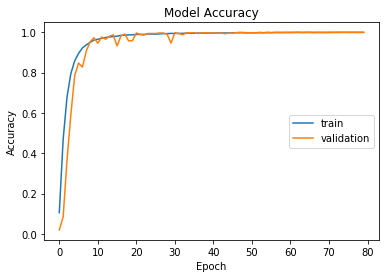

In [19]:
# summarize history for model accuracy
history = train_history["OptIterHistory"]
plt.plot(1.-history["FitError"])
plt.plot(1.-history["ValidError"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

### 3.6 Evaluate the Smaller EfficientNet Model <a name="evaluate-smaller-effb0"></a> 

In [20]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, topprobs=5)

NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.


,Descr,Value
0,Number of Observations Read,20622
1,Number of Observations Used,20622
2,Misclassification Error (%),1.721463
3,Top 5 Misclassification Error (%),0.227912
4,Loss Error,0.063818


We can see that the smaller EfficientNet model can still achieves great accuracy, yet it is smaller and  can be trained faster  than the EfficientNet-B0 model.

## 4. Deploy Model <a name="deployment"></a> 

In [21]:
#Save model as an ASTORE for deployment
#model = effnetb0_small
model.deploy(output_format='astore', path='/dlpy/data_dir/')

NOTE: Model astore file saved successfully.


## 5. Summary <a name="summary"></a> 

The EfficientNet architecture provides a simple and efficient way to scale up or down models. Compared to other popular CNN models such as ResNet and MobileNets, the EfficientNet models can often achieve better accuracy and faster inference with similar or smaller model sizes. This notebook example demonstrates how we can easily build EfficientNet models to accurately classify fruits and vegetables.

## Reference
- [Fruits-360: A dataset of images containing fruits and vegetables](https://github.com/Horea94/Fruit-Images-Dataset)
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)
- [Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning)


### Close the CAS Session to Free Resources

In [22]:
s.endsession()

+ Elapsed: 0.000107s, sys: 9.7e-05s, mem: 0.203mb